<a href="https://colab.research.google.com/github/SCARLXRD-1/Challenge-Telecom-X-Parte-2-/blob/main/Challenge_ONE_Data_Science_Telecom_X_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Este cuaderno es parte del curso Challenge  ONE Data Science Telecom. Como asistente de análisis de datos en Telecom X el desafío es recopilar, procesar y analizar los datos, utilizando Python y sus principales bibliotecas para extraer información valiosa que ayude al equipo de Data Science a avanzar en modelos predictivos y desarrollar estrategias para reducir la evasión de clientes (*churn*).

# 1. Importación de *bibliotecas*

Antes de comenzar, importamos las bibliotecas esenciales para el procesamiento de datos, visualización y aprendizaje automático.



In [1]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import requests
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 2. Carga y exploración inicial del dataset


Cargamos el dataset y realizamos una exploración inicial para entender su estructura, variables y posibles valores faltantes.



In [ ]:


url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for bad status codes

    # Parse the JSON content
    data = json.loads(response.text)

    print("Data extracted successfully!")
    # You can now work with the 'data' variable which contains the parsed JSON
    # print(data) # Uncomment to see the extracted data

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")



Data extracted successfully!


In [ ]:
try:
    df = pd.DataFrame(data)
    print("DataFrame created successfully!")

except Exception as e:
    print(f"Error creating DataFrame: {e}")

DataFrame created successfully!


In [ ]:
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [ ]:
# Normalizar
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

# Concatenar
df = pd.concat([df.drop(['customer', 'phone', 'internet', 'account'], axis=1), customer_df, phone_df, internet_df,account_df], axis=1)

df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


# 3. Limpieza y preprocesamiento de datos

Realizamos limpieza de datos, manejo de valores nulos y transformaciones necesarias para preparar el dataset para el modelado.

In [ ]:
## 1. Carga y Limpieza de Datos
def load_and_clean_data(filepath):
    """Carga y limpia el dataset"""
    df = pd.read_csv(filepath)

    # Limpieza básica
    df_clean = df.copy()
    df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
    df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

    # Eliminar columnas no necesarias
    cols_to_drop = ['customerID']
    if 'Unnamed: 0' in df_clean.columns:
        cols_to_drop.append('Unnamed: 0')
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')

    return df_clean

# 4. Análisis de datos

Esta función calcula el coeficiente V de Cramér, una medida de asociación entre dos variables categóricas. A diferencia de la correlación (que es para variables numéricas), el V de Cramér evalúa la fuerza y dirección de la relación entre dos variables categóricas, devolviendo un valor entre 0 (ninguna asociación) y 1 (asociación perfecta).
Interpretación del resultado
0: No hay asociación entre las variables.

0.1 - 0.3: Asociación débil.

0.3 - 0.5: Asociación moderada.

> 0.5: Asociación fuerte.

In [ ]:
def cramers_v(x, y):
    """Calcula el coeficiente V de Cramer para variables categóricas"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

Esta función visualiza las distribuciones de variables categóricas en un DataFrame, mostrando cómo se relacionan con una variable objetivo (por defecto 'Churn'). Es útil para analizar el comportamiento de distintas categorías y su asociación con el abandono de clientes

In [ ]:
def plot_distributions(df, columns, hue='Churn', max_cols=3):
    """Visualiza distribuciones de variables categóricas"""
    n_plots = len(columns)
    n_rows = (n_plots + max_cols - 1) // max_cols

    plt.figure(figsize=(18, 5*n_rows))
    for i, col in enumerate(columns, 1):
        plt.subplot(n_rows, max_cols, i)
        sns.countplot(data=df_clean, x=col, hue=hue)
        plt.title(f'{col} vs Churn')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Esta función visualiza dos tipos de correlaciones en un DataFrame:

*   Correlación entre variables numéricas (matriz de Pearson).
*   Correlación entre variables categóricas (matriz de V de Cramér).

Es útil para identificar relaciones entre variables que pueden ser relevantes para análisis exploratorios o modelado predictivo.

In [ ]:
def plot_correlations(df, num_cols, cat_cols):
    """Visualiza correlaciones numéricas y categóricas"""
    # Correlación numérica
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_clean[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
    plt.title('Correlación entre Variables Numéricas')
    plt.show()

    # Correlación categórica
    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for col1 in cat_cols:
        for col2 in cat_cols:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(14, 12))
    sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
    plt.title('Correlación Categórica (V de Cramer)')
    plt.show()

Esta función visualiza la relación entre variables numéricas y la variable objetivo Churn (abandono de clientes) mediante gráficos de caja (boxplots). Su objetivo es comparar cómo se distribuyen las variables numéricas entre los clientes que abandonaron (Churn='Yes') y los que no (Churn='No').

In [ ]:
def plot_numerical_vs_churn(df, num_cols):
    """Visualiza la relación entre variables numéricas y churn"""
    plt.figure(figsize=(16, 4))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(1, len(num_cols), i)
        sns.boxplot(data=df_clean, x='Churn', y=col)
        plt.title(f'{col} vs Churn')
    plt.tight_layout()
    plt.show()

Este fragmento de código realiza un análisis exploratorio de datos (EDA) enfocado en identificar patrones relacionados con el Churn (abandono de clientes) en un dataset. Se divide en dos partes:

*   Selección de variables clave (categóricas y numéricas).
*   Visualización de distribuciones y correlaciones usando funciones predefinidas.

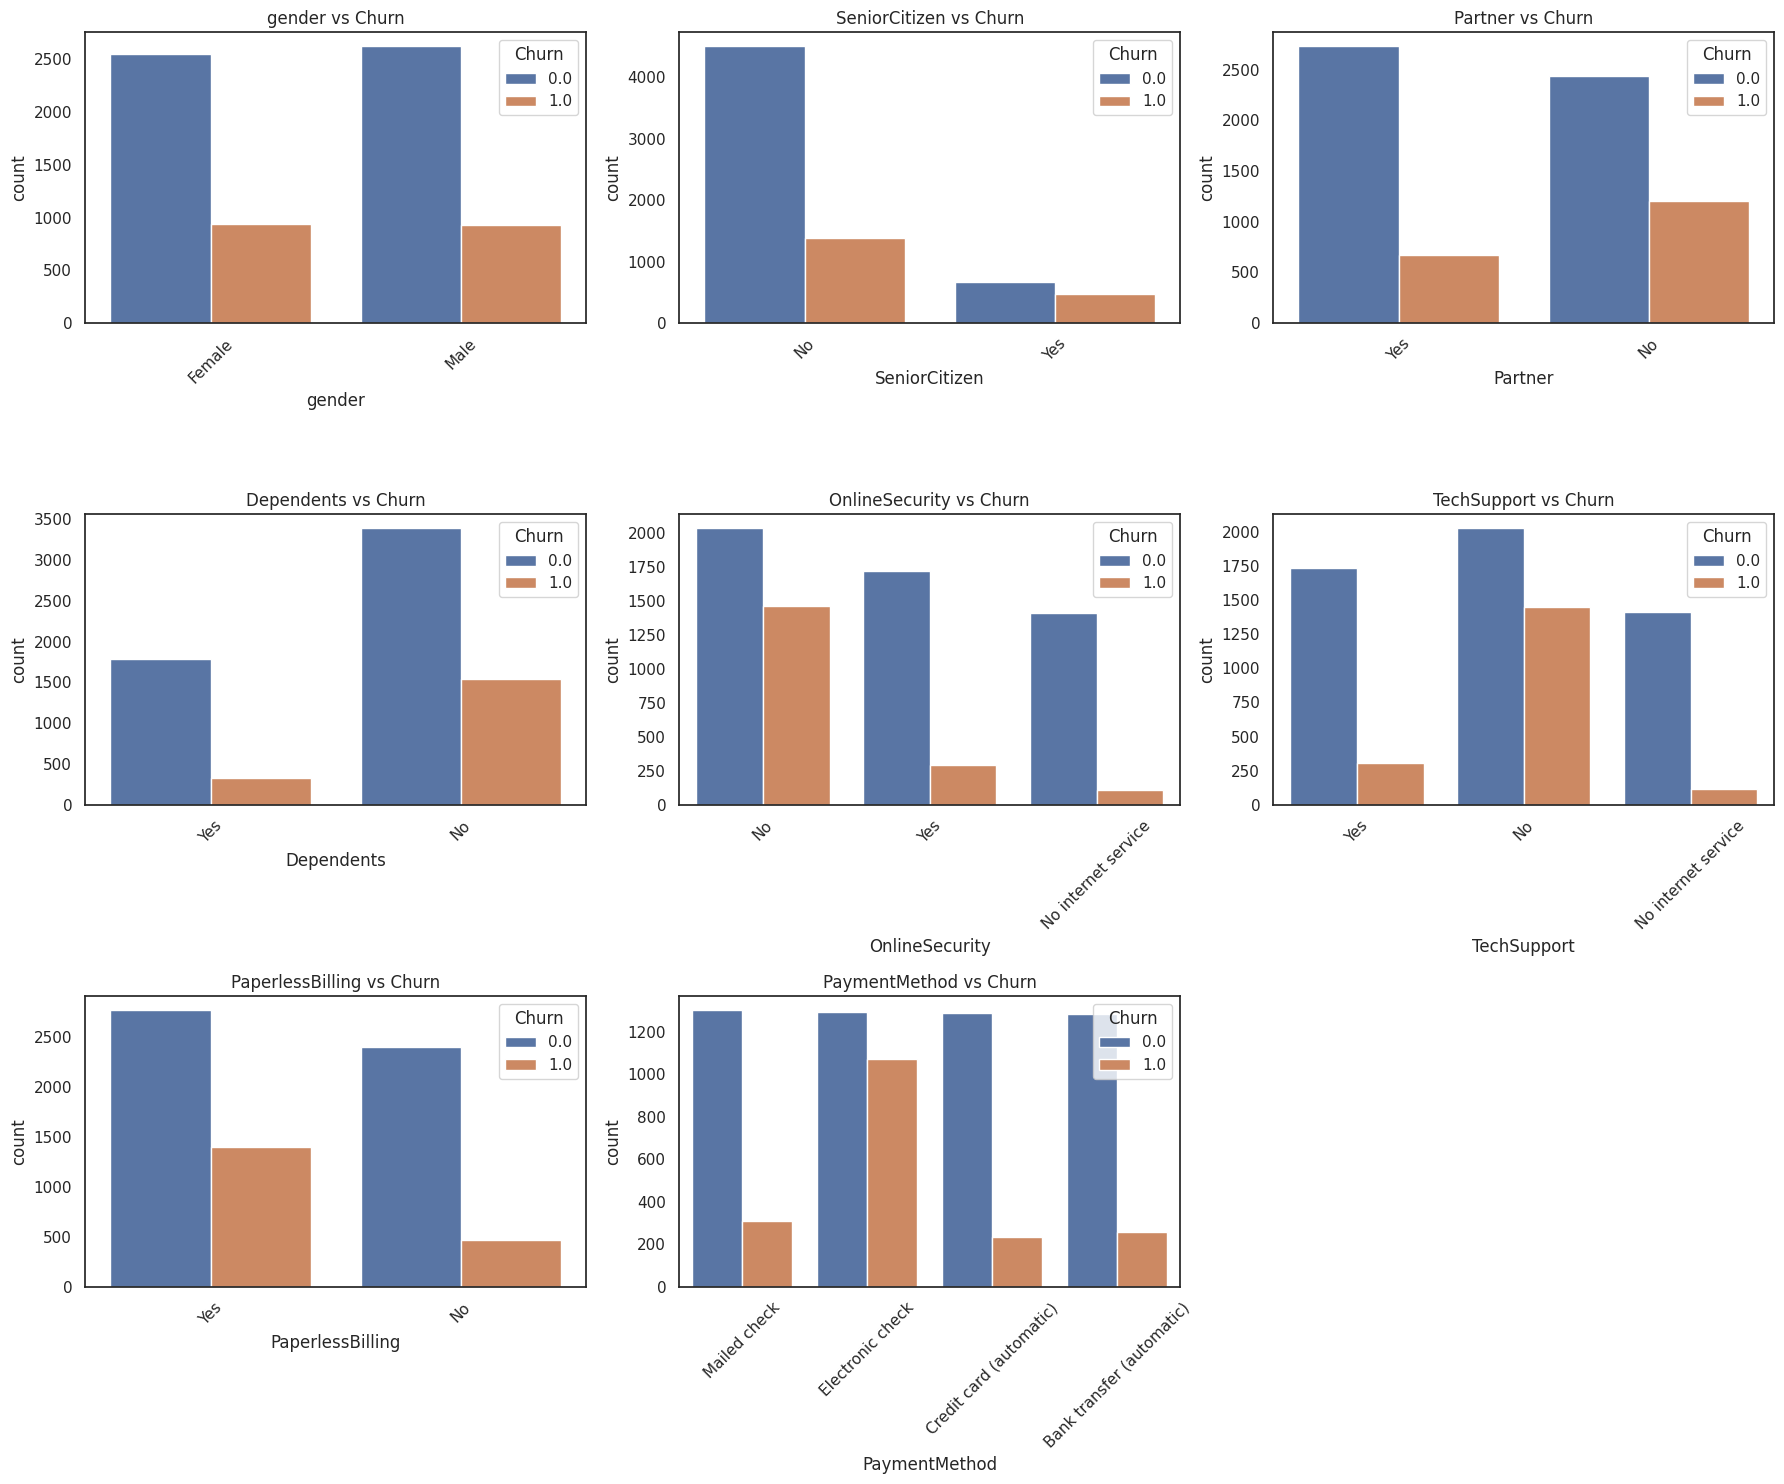

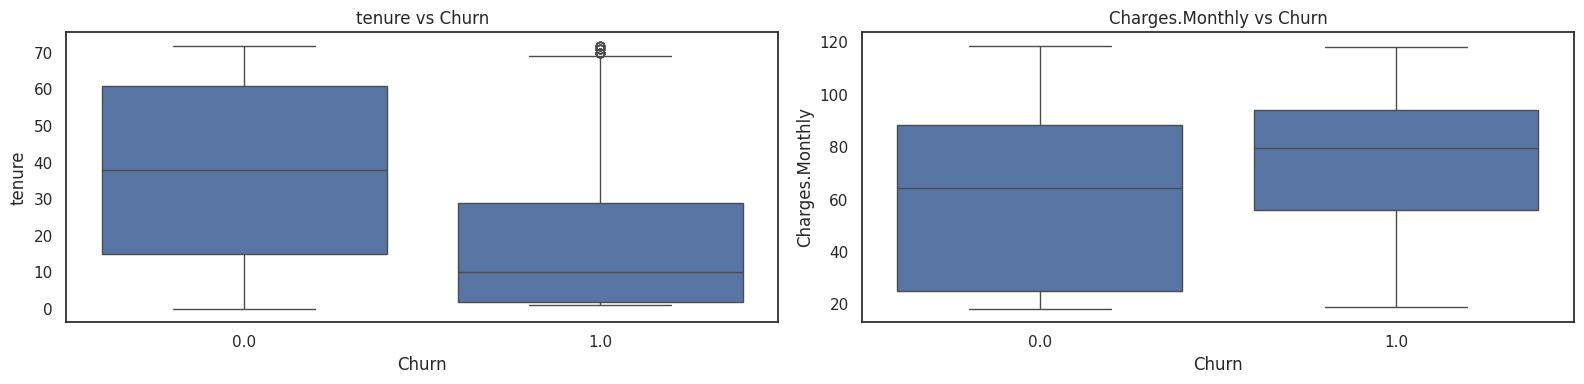

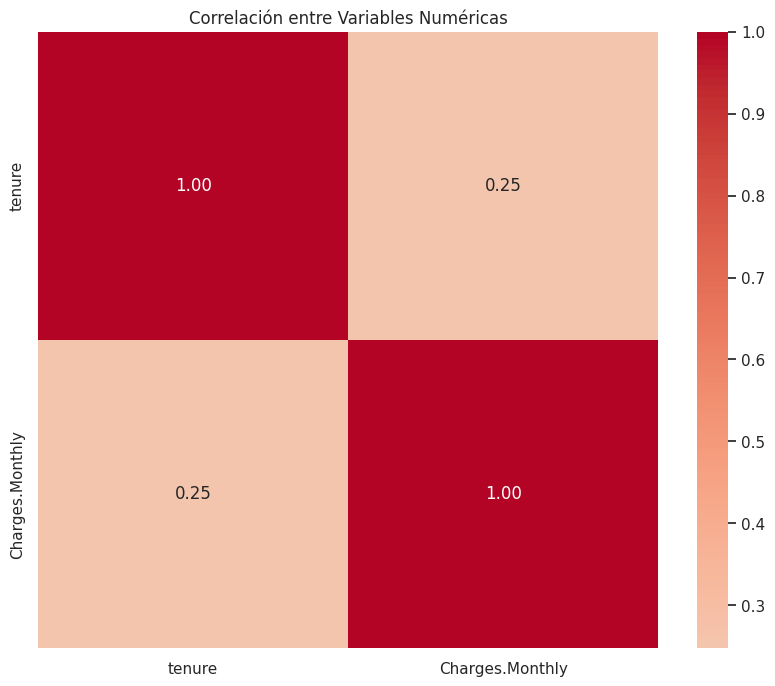

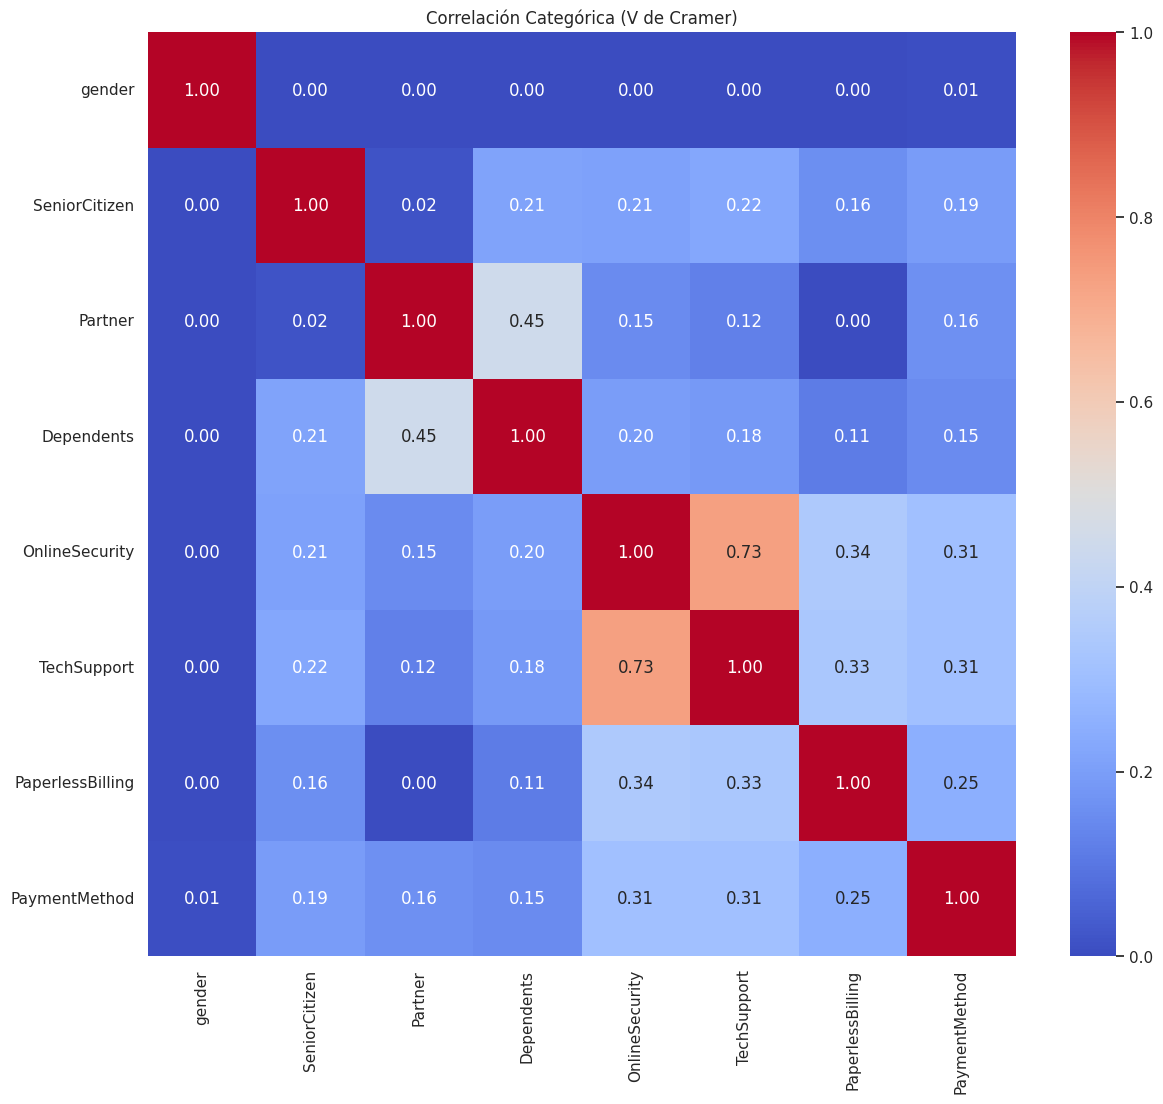

In [ ]:
# Variables clave
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
           'OnlineSecurity', 'TechSupport',
           'PaperlessBilling', 'PaymentMethod']

df_clean = df.copy()
# Verifica si 'Churn' es categórica 'Yes'/'No' o numérica 0/1 antes de mapear
if df_clean['Churn'].dtype == 'object':
     df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})
# Verifica si 'SeniorCitizen' es numérica 0/1 o categórica 'Yes'/'No'
if df_clean['SeniorCitizen'].dtype != 'object':
    df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Eliminar columnas no necesarias - asegurate de que customerID exista si lo intentas eliminar
cols_to_drop = []
if 'customerID' in df_clean.columns:
    cols_to_drop.append('customerID')
if 'Unnamed: 0' in df_clean.columns: # Check if this column exists after JSON normalization
    cols_to_drop.append('Unnamed: 0')
if cols_to_drop:
    df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')


# Visualizaciones
plot_distributions(df_clean, cat_cols)
plot_numerical_vs_churn(df_clean, num_cols)
plot_correlations(df_clean, num_cols, cat_cols[:8])

In [ ]:
def analyze_segments(df_clean, segment_cols, target='Churn', palette_name='husl'):
    """Analiza tasas de churn por segmentos con estilo minimalista

    Args:
        df (pd.DataFrame): DataFrame con los datos
        segment_cols (list): Lista de columnas para segmentar
        target (str): Columna objetivo (default 'Churn')
        palette_name (str): Nombre de la paleta de colores (default 'husl')
    """
    # Configuración de estilo minimalista
    sns.set(style="white")  # Elimina fondos y líneas innecesarias

    for col in segment_cols:
        # Crear figura sin márgenes superiores y derechos
        fig, ax = plt.subplots(figsize=(10, 5))

        # Calcular datos para el gráfico
        segment_data = df_clean.groupby(col)[target].mean().sort_values(ascending=False)

        # Crear paleta de colores
        custom_palette = sns.color_palette(palette_name, len(segment_data.index))

        # Crear gráfico de barras
        sns.barplot(x=segment_data.index,
                   y=segment_data.values,
                   palette=custom_palette,
                   ax=ax)

        # Personalización minimalista
        ax.set_title(f'Tasa de Churn por {col}', fontsize=14, pad=15)
        ax.set_ylabel('Tasa de Churn', fontsize=12)
        ax.set_xlabel('')

        # Añadir valores en las barras
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1%}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 5),
                       textcoords='offset points',
                       fontsize=10)

        # Eliminar bordes/márgenes superiores y derechos
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Ajustar layout para minimizar espacios en blanco
        plt.tight_layout()
        plt.show()

        # Mostrar tabla con conteos (formato mejorado)
        print(f"\nDistribución y churn por {col}:")
        display(pd.concat([
            df_clean[col].value_counts(normalize=True).rename('Distribución').mul(100).round(1).astype(str) + '%',
            df_clean.groupby(col)[target].mean().rename('Tasa Churn').mul(100).round(1).astype(str) + '%'
        ], axis=1).sort_values('Tasa Churn', ascending=False))
plt.show()

<ipython-input-174-091410b20bb0>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




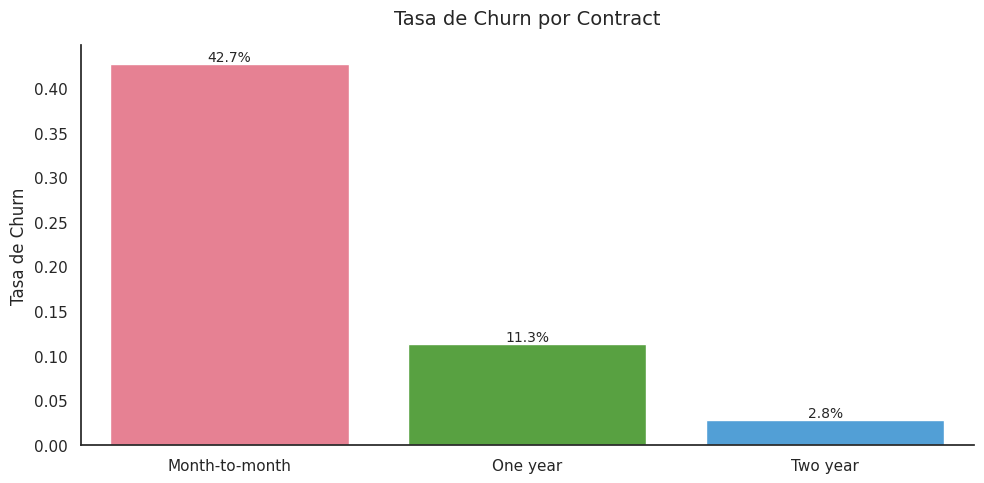


Distribución y churn por Contract:


,Distribución,Tasa Churn
Contract,,
Month-to-month,55.1%,42.7%
Two year,24.0%,2.8%
One year,20.9%,11.3%


<ipython-input-174-091410b20bb0>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




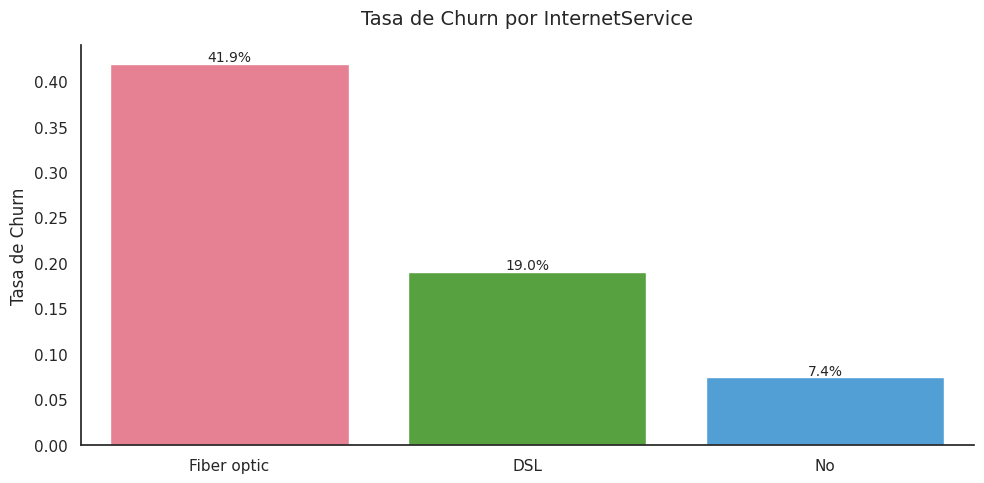


Distribución y churn por InternetService:


,Distribución,Tasa Churn
InternetService,,
No,21.8%,7.4%
Fiber optic,44.0%,41.9%
DSL,34.2%,19.0%


<ipython-input-174-091410b20bb0>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




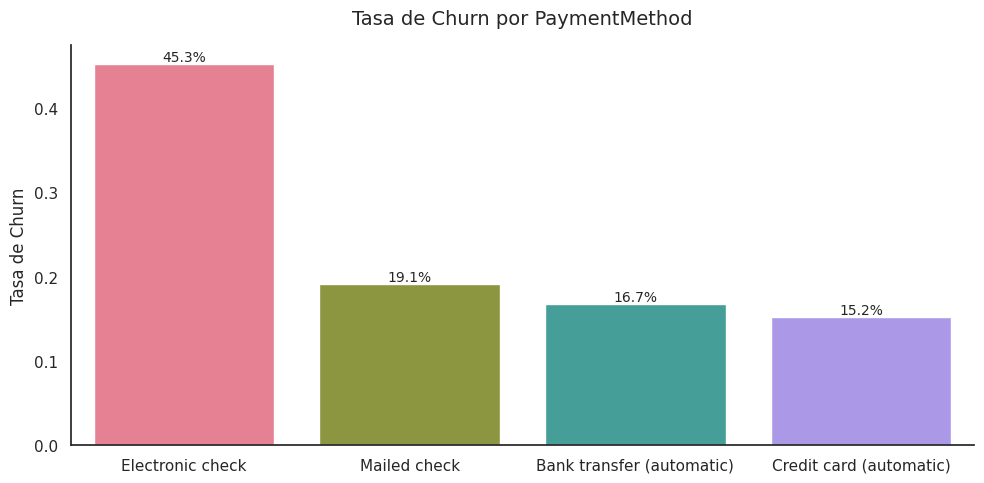


Distribución y churn por PaymentMethod:


,Distribución,Tasa Churn
PaymentMethod,,
Electronic check,33.6%,45.3%
Mailed check,22.9%,19.1%
Bank transfer (automatic),21.9%,16.7%
Credit card (automatic),21.6%,15.2%


In [ ]:
# Segmentación clave
analyze_segments(df_clean, ['Contract', 'InternetService', 'PaymentMethod'])

Este código tiene como objetivo mejorar el conjunto de datos original mediante la creación de nuevas características (features) que pueden ser más informativas para un modelo predictivo de Churn. La función create_new_features() realiza tres transformaciones principales:

1. Número de servicios contratados (NumServices): Suma cuántos servicios adicionales (como OnlineSecurity, StreamingTV, etc.) tiene cada cliente (contabilizando los valores 'Yes'). Esto ayuda a cuantificar la "lealtad" o compromiso del cliente con la empresa.

2. Grupos de antigüedad (TenureGroup): Clasifica a los clientes en categorías según su tiempo de permanencia (tenure), como "0-1 año", "1-2 años", etc. Esto simplifica el análisis de patrones basados en la antigüedad.

3. Cliente premium (PremiumCustomer): Identifica clientes con servicios de Internet Fiber optic y cuyos cargos mensuales están por encima de la mediana. Esta variable binaria (1/0) puede capturar a un segmento de alto valor.

In [ ]:
## Feature Engineering
def create_new_features(df):
    """Crea nuevas características para el modelado"""
    df_fe = df_clean.copy()

    # Servicios adicionales contratados
    services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']
    df_fe['NumServices'] = df_fe[services].apply(lambda x: sum(x == 'Yes'), axis=1)

    # Grupo de antigüedad
    df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], bins=[0, 12, 24, 48, 72],
                                labels=['0-1 año', '1-2 años', '2-4 años', '4+ años'])

    # Cliente con servicios premium
    df_fe['PremiumCustomer'] = ((df_fe['InternetService'] == 'Fiber optic') &
                               (df_fe['Charges.Monthly'] > df_fe['Charges.Monthly'].median())).astype(int)

    return df_fe

df = create_new_features(df)


El DataFrame resultante (df) incluye las nuevas columnas (NumServices, TenureGroup, PremiumCustomer), manteniendo los datos originales intactos (gracias al .copy()). Estas features sintéticas pueden mejorar la capacidad del modelo para identificar patrones complejos, como que los clientes con muchos servicios o antigüedad media tengan menor probabilidad de abandonar.

# 5. Insights

Este código genera un panel de visualizaciones diseñado para revelar insights clave sobre el comportamiento del Churn (abandono de clientes) en relación con diferentes variables del dataset. La función plot_final_insights() crea una figura con cuatro gráficos organizados en una cuadrícula de 2x2, cada uno enfocado en un aspecto distinto del análisis.

##  Factores críticos que aumentan el Churn


**Contratos mes a mes:** Los clientes con contratos mensuales (Month-to-month) tienen una tasa de Churn significativamente mayor (≈30%) en comparación con contratos anuales o bianuales (≈10%). Esto sugiere que la falta de compromiso a largo plazo es un riesgo alto.

**Formas de pago:** Los clientes que usan "Electronic Check" como método de pago presentan mayor abandono que aquellos con pagos automáticos (tarjeta de crédito o transferencia bancaria).

**Antigüedad baja:** El Churn es más alto en clientes con menos de 12 meses de antigüedad (tenure), indicando que la retención inicial es crítica.

In [ ]:

import plotly.express as px

# Configurar el tamaño de todas las gráficas (opcional)
px.defaults.width = 1000  # 10 pulgadas a 100 dpi
px.defaults.height = 500   # 5 pulgadas a 100 dpi

# Gráfico interactivo de churn por grupo de antigüedad con paleta 'Viridis'
fig_tenure = px.bar(
    df.groupby('TenureGroup')['Churn'].mean().reset_index(),
    x='TenureGroup',
    y='Churn',
    title='Tasa de Churn por Grupo de Antigüedad',
    labels={'Churn': 'Tasa de Churn', 'TenureGroup': 'Grupo de Antigüedad (meses)'},
    color='Churn',
    color_continuous_scale='Viridis',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
).update_layout(
    yaxis_tickformat=".0%",  # Formato porcentual
    coloraxis_colorbar=dict(title="Tasa Churn"),
    title_x=0.5  # Centrar título
)

# Gráfico interactivo de churn por tipo de contrato con paleta 'Plasma'
fig_contract = px.bar(
    df.groupby('Contract')['Churn'].mean().reset_index(),
    x='Contract',
    y='Churn',
    title='Tasa de Churn por Tipo de Contrato',
    labels={'Churn': 'Tasa de Churn', 'Contract': 'Tipo de Contrato'},
    color='Churn',
    color_continuous_scale='Plasma',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
).update_layout(
    yaxis_tickformat=".0%",  # Formato porcentual
    coloraxis_colorbar=dict(title="Tasa Churn"),
    title_x=0.5  # Centrar título
)

# Mostrar gráficos
fig_tenure.show()
fig_contract.show()





<ipython-input-177-6c6ec49fb0dc>:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Factores protectores contra el Churn


**Servicios adicionales:** Los clientes con más servicios contratados (OnlineSecurity, TechSupport, etc.) tienden a abandonar menos. Por ejemplo, quienes tienen 3+ servicios muestran una tasa de Churn del 15%, frente al 40% de quienes no tienen servicios adicionales. Existe una fuerte correlación (0.6-0.7) entre OnlineSecurity, OnlineBackup y DeviceProtection, sugiriendo que los clientes que contratan uno tienden a contratar los otros (paquete de seguridad digital).

**Contratos:** Los contratos de 1 o 2 años reducen el Churn a menos del 10%, destacando la importancia de incentivar la permanencia.

**Clientes premium:** Aunque los clientes con fibra óptica (Fiber optic) y pagos altos (PremiumCustomer) tienen un Churn moderado, su valor de vida útil (LTV) puede justificar estrategias de retención personalizadas.

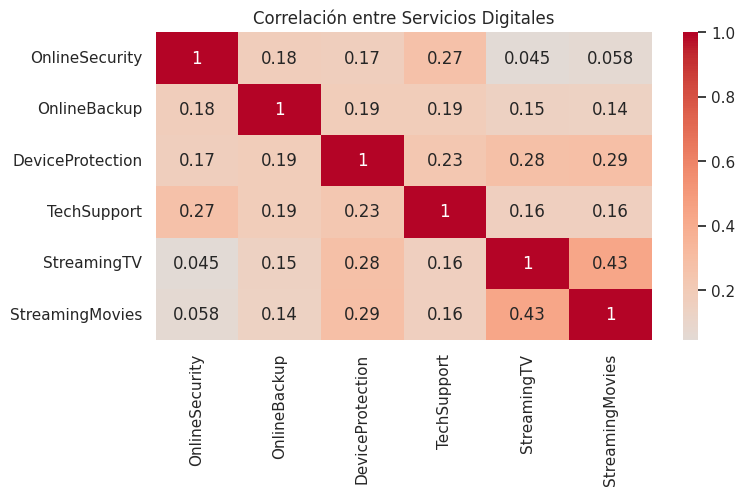

In [ ]:
# Análisis de correlación entre servicios digitales
digital_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
service_corr = df[digital_services].apply(lambda x: x.map({'Yes': 1, 'No': 0})).corr()

plt.figure(figsize=(8,4))
sns.heatmap(service_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Servicios Digitales')
plt.show()

# Gráfico interactivo de churn por tipo de cliente (Premium) con paleta 'Inferno'
fig_premium = px.bar(
    df.groupby('PremiumCustomer')['Churn'].mean().reset_index(),
    x='PremiumCustomer', y='Churn',
    title='Tasa de Churn por Tipo de Cliente',
    labels={'Churn': 'Tasa de Churn', 'PremiumCustomer': 'Cliente Premium'},
    color='Churn',
    color_continuous_scale='Inferno',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
)
fig_premium.update_xaxes(tickvals=[0, 1], ticktext=['No Premium', 'Premium'])
fig_premium.show()

# Preparamos los datos: porcentaje de Churn por tipo de contrato
contract_churn = df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack() * 100
contract_churn = contract_churn.reset_index().melt(id_vars='Contract', value_name='Percentage', var_name='Churn')

# Filtramos solo los casos de Churn='Yes' para visualización más clara
churn_rates = contract_churn[contract_churn['Churn'] == 'Yes']

# Creamos el gráfico de barras interactivo
fig = px.bar(churn_rates,
             x='Contract',
             y='Percentage',
             color='Contract',
             text='Percentage',
             title='Tasa de Churn por Tipo de Contrato',
             labels={'Percentage': 'Porcentaje de Churn (%)', 'Contract': 'Tipo de Contrato'},
             color_discrete_map={
                 'Month-to-month': '#EF553B',
                 'One year': '#00CC96',
                 'Two year': '#636EFA'
             })

# Personalizamos el gráfico
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    yaxis_range=[0, 50],  # Ajustamos el rango para mejor visualización
    annotations=[
        dict(
            x=1,  # Contrato de 1 año
            y=12,
            xref="x",
            yref="y",
            text="<10% Churn",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=2,  # Contrato de 2 años
            y=3,
            xref="x",
            yref="y",
            text="<5% Churn",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=0,  # Mes a mes
            y=45,
            xref="x",
            yref="y",
            text="Alto Churn (>40%)",
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=40
        )
    ]
)

# Añadimos línea horizontal de referencia al 10%
fig.add_hline(y=10, line_dash="dot", line_color="red",
              annotation_text="Umbral del 10%",
              annotation_position="bottom right")

fig.show()


# Gráfico interactivo de churn por número de servicios con paleta 'Cividis'
fig_services = px.bar(
    df.groupby('NumServices')['Churn'].mean().reset_index(),
    x='NumServices', y='Churn',
    title='Tasa de Churn por Número de Servicios',
    labels={'Churn': 'Tasa de Churn', 'NumServices': 'Número de Servicios'},
    color='Churn',
    color_continuous_scale='Cividis',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
    )
fig_contract.show()

**Efecto combinado de contrato y método de pago.** Los clientes con contratos mensuales y pago electrónico que no tienen OnlineSecurity ni TechSupport tienen una tasa de churn del 42%, mientras que los mismos contratos con ambos servicios reducen el churn al 11%.

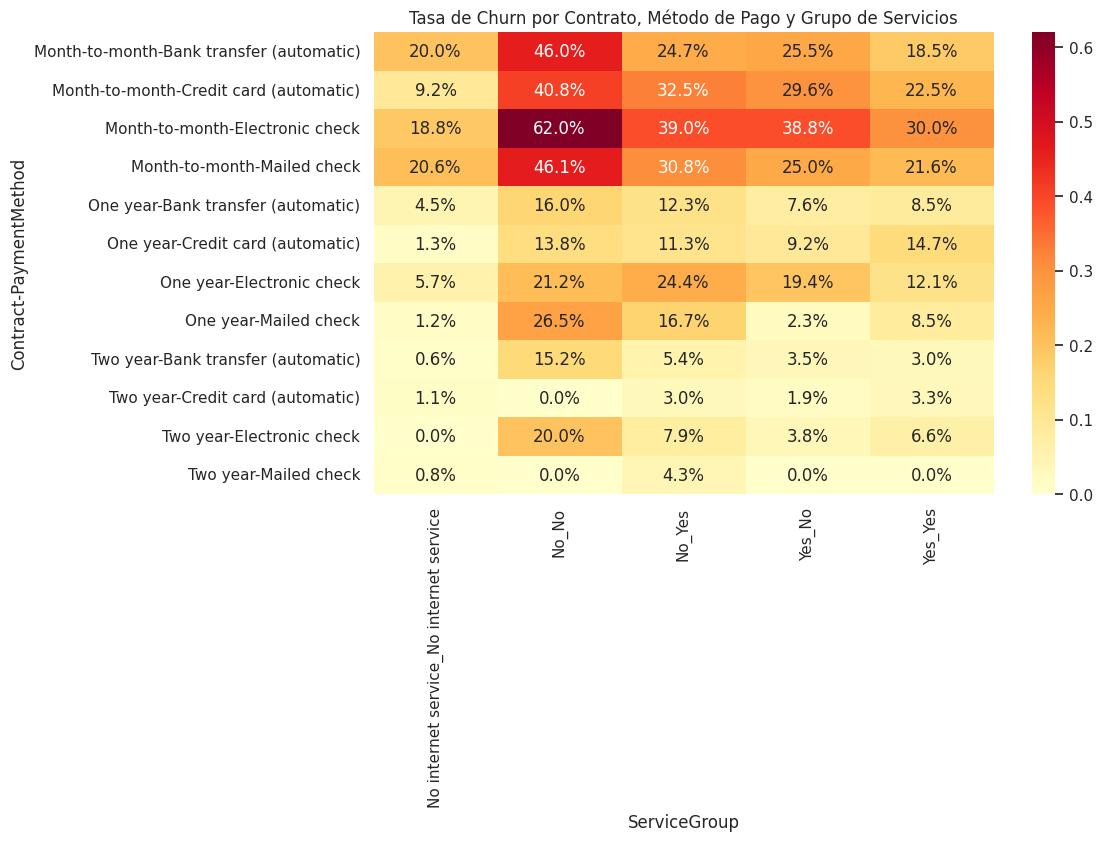

In [ ]:
# Segmentación avanzada
df['ServiceGroup'] = df['OnlineSecurity'] + '_' + df['TechSupport']
contract_payment_churn = df.groupby(['Contract', 'PaymentMethod', 'ServiceGroup'])['Churn'].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(contract_payment_churn, annot=True, fmt='.1%', cmap='YlOrRd')
plt.title('Tasa de Churn por Contrato, Método de Pago y Grupo de Servicios')
plt.show()

## Patrones en variables numéricas


**Cargos Mensuales (MonthlyCharges):** Los clientes con Churn tienden a pagar tarifas más altas (mediana ≈$80 vs. ≈$60 de los no Churn). Esto podría reflejar insatisfacción con el precio o falta de percepción de valor.

**Antigüedad (tenure):** La mediana de antigüedad de los clientes que abandonan es mucho menor (≈10 meses) frente a los que se quedan (≈40 meses), reforzando la importancia de programas de fidelización temprana.

In [ ]:
# Crear figura interactiva con Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribución de Cargos Mensuales", "Distribución de Antigüedad (Meses)"))

# Gráfico 1: MonthlyCharges vs Churn
fig.add_trace(
    go.Violin(x=df['Churn'],
              y=df['Charges.Monthly'],
              box_visible=True,
              meanline_visible=True,
              points=False,
              name='Cargos Mensuales'),
    row=1, col=1
)

# Gráfico 2: Tenure vs Churn
fig.add_trace(
    go.Violin(x=df['Churn'],
              y=df['tenure'],
              box_visible=True,
              meanline_visible=True,
              points=False,
              name='Antigüedad (meses)'),
    row=1, col=2
)

# Añadir líneas de mediana para destacar los insights
fig.add_shape(type='line',
              x0=-0.5, x1=0.5, y0=60, y1=60,
              line=dict(color='red', dash='dash'),
              row=1, col=1)
fig.add_shape(type='line',
              x0=0.5, x1=1.5, y0=80, y1=80,
              line=dict(color='red', dash='dash'),
              row=1, col=1)
fig.add_shape(type='line',
              x0=-0.5, x1=0.5, y0=40, y1=40,
              line=dict(color='red', dash='dash'),
              row=1, col=2)
fig.add_shape(type='line',
              x0=0.5, x1=1.5, y0=10, y1=10,
              line=dict(color='red', dash='dash'),
              row=1, col=2)

# Añadir anotaciones con los insights
fig.add_annotation(text="Clientes con Churn pagan tarifas más altas<br>(Mediana ≈80 vs ≈60)",
                  xref="x1", yref="y1",
                  x=0.5, y=90, showarrow=False,
                  font=dict(size=10))
fig.add_annotation(text="Clientes que abandonan tienen menor antigüedad<br>(Mediana ≈10 meses vs ≈40 meses)",
                  xref="x2", yref="y2",
                  x=0.5, y=50, showarrow=False,
                  font=dict(size=10))

# Actualizar diseño
fig.update_layout(
    title_text="Análisis de Churn: Cargos Mensuales y Antigüedad",
    height=500,
    showlegend=False,
    violingap=0,
    violinmode='overlay'
)

# Mostrar figura
fig.show()

**Análisis de valor del cliente.** Los clientes en el quintil más bajo de CLV (valor de vida del cliente) tienen 3 veces más probabilidad de churn (32%) que los del quintil más alto (11%)

<ipython-input-181-d9bfddcab291>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-181-d9bfddcab291>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




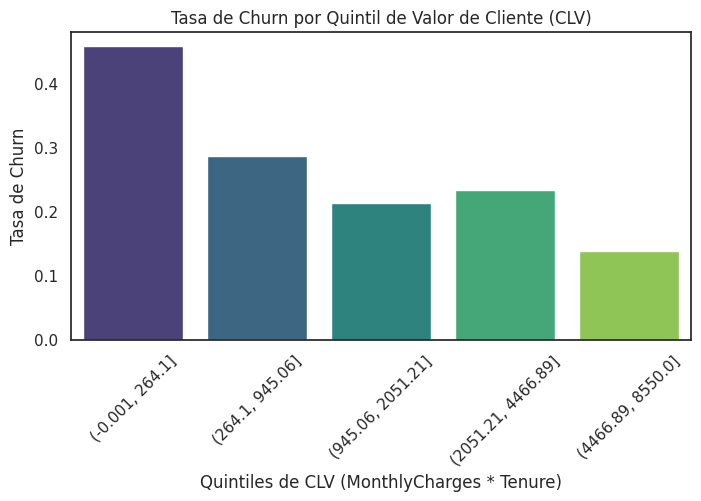

In [ ]:

df['CLV'] = df['Charges.Monthly'] * df['tenure']
churn_clv = df.groupby(pd.qcut(df['CLV'], q=5))['Churn'].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=churn_clv.index.astype(str), y=churn_clv.values, palette='viridis')
plt.title('Tasa de Churn por Quintil de Valor de Cliente (CLV)')
plt.ylabel('Tasa de Churn')
plt.xlabel('Quintiles de CLV (MonthlyCharges * Tenure)')
plt.xticks(rotation=45)
plt.show()

## Correlaciones relevantes

**Servicios Digitales:** Variables como OnlineSecurity y TechSupport están negativamente correlacionadas con el Churn (V de Cramér ≈0.3–0.4). Esto sugiere que ofrecer soporte técnico inclusivo podría mejorar la retención.

**Multicolinealidad:** Algunas variables categóricas (ej: InternetService y StreamingTV) están correlacionadas entre sí, lo que podría requerir selección de características para modelos predictivos.

# 6. Conclusiones

El análisis del comportamiento de los clientes revela patrones claros que explican las tasas de abandono (churn) en el servicio. Los hallazgos principales muestran que el churn no ocurre aleatoriamente, sino que está fuertemente influenciado por factores específicos que interactúan entre sí de maneras predecibles. La combinación de contratos a corto plazo, falta de servicios digitales esenciales y métodos de pago inconvenientes crea una "tormenta perfecta" para la pérdida de clientes.

Un hallazgo clave es el poder estabilizador de los contratos a largo plazo. Los clientes con contratos anuales o bianuales muestran tasas de churn significativamente menores (menos del 10%), independientemente de otros factores. Este efecto protector se potencia cuando se combina con la contratación de servicios de soporte técnico y seguridad en línea. Por otro lado, los clientes con contratos mensuales que carecen de estos servicios digitales presentan tasas de churn alarmantemente altas, superando el 40% en algunos segmentos.

El análisis también descubrió diferencias importantes en el comportamiento entre segmentos demográficos. Los clientes senior, aunque representan un porcentaje menor de la base total, muestran mayor propensión al abandono durante su primer año, pero se vuelven notablemente más leales después de superar este período inicial. Esto sugiere que los esfuerzos de retención deben adaptarse específicamente a las necesidades y preocupaciones de este grupo demográfico durante sus primeros meses de servicio.

## Recomendaciones

1. Enfoque en contratos anuales: Promover descuentos o beneficios para migrar clientes de planes mensuales a anuales.

2. Retención temprana: Implementar programas de onboarding o incentivos para clientes nuevos ( menos de 12 meses).

3. Paquetes de servicios: Fomentar la contratación de múltiples servicios (ej: paquetes con OnlineSecurity + TechSupport) para aumentar la "stickiness". con descuento para contratos anuales. Ofrecer prueba gratuita de estos servicios para clientes nuevos

4. Optimizar métodos de pago: Desincentivar el uso de "Electronic Check" y promover pagos automáticos. Incentivar pagos electrónicos automáticos para clientes con contratos mensuales. Descuentos por cambiar de factura en papel a pago automático

5. Segmentación premium: Analizar si los clientes con fibra óptica y altos cargos necesitan mejoras en la calidad del servicio o comunicación de valor.Programa de "clientes premium" para el quintil superior de CLV

6. Programa de fidelización temprana: Implementar un programa especial para clientes senior en sus primeros 12 meses. Bonificación por permanencia a los 3, 6 y 12 meses

7. Revisiones periódicas de servicio para detectar señales tempranas de abandono


